In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using CUDA

In [4]:
using Statistics

In [87]:
n_x = 101
phases = range(-1.0, 1.0, n_x) |> collect
phases = reshape(phases, (:,1));

In [88]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [89]:
import .PhasorNetworks: bias_current, parallel_current, parallel_scatter_add

In [90]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [91]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [92]:
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [93]:
st = phase_to_train(phases, spk_args=spk_args, repeats = repeats, offset=0.0f0)

Spike Train: (101, 1) with 606 spikes.

In [94]:
sol = oscillator_bank(st, tspan=tspan, spk_args=spk_args);

In [95]:
u = Array(sol);

In [96]:
u |> size

(101, 1, 602)

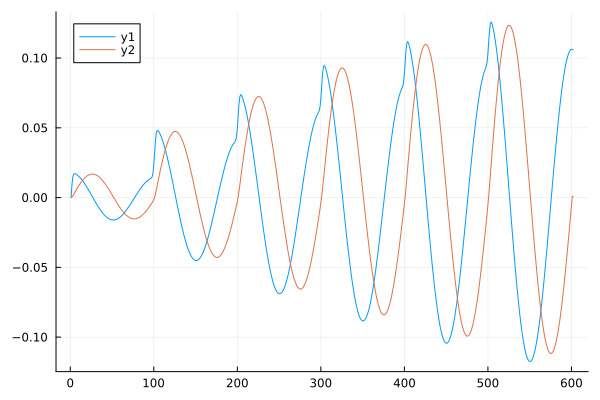

In [98]:
plot(real.(u[1,1,:]))
plot!(imag.(u[1,1,:]))

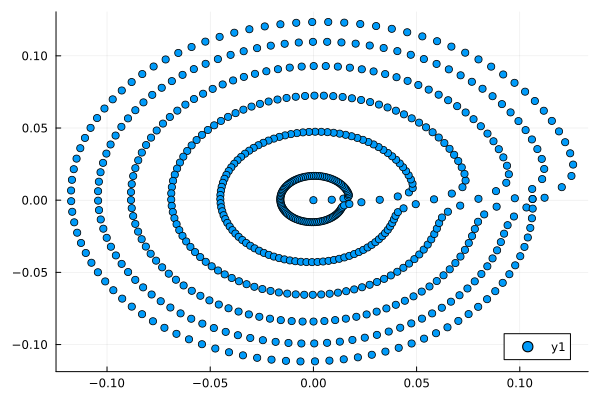

In [99]:
scatter(real.(u[1,1,:]), imag.(u[1,1,:]))

In [100]:
p = solution_to_phase(sol, spk_args=spk_args, final_t=false);

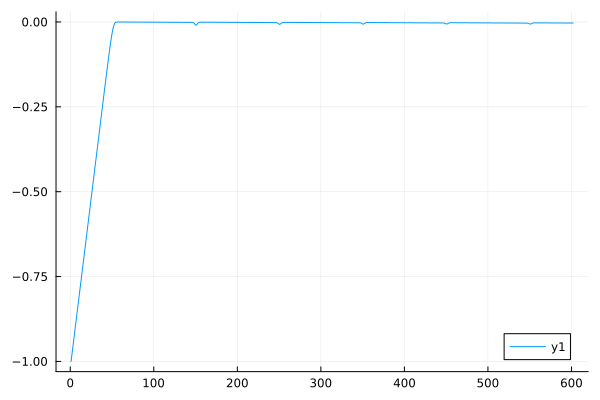

In [103]:
plot(p[51,1,:])

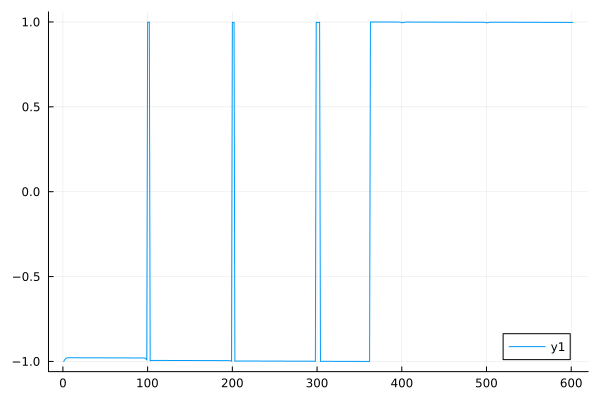

In [ ]:
plot(p[1,:])

In [104]:
typeof(u)

Array{ComplexF32, 3}

In [102]:
st1 = solution_to_train(sol, tspan, spk_args = spk_args, offset=0.0)

Spike Train: (101, 1) with 606 spikes.

In [108]:
p1 = train_to_phase(st1, spk_args=spk_args)

6×101×1 Array{Float64, 3}:
[:, :, 1] =
 0.997326  -0.982654  -0.962014  -0.941465  …  0.955291  0.968571  0.997326
 0.996732  -0.983247  -0.962607  -0.942058     0.956919  0.973878  0.996732
 0.996182  -0.983797  -0.963157  -0.942608     0.957058  0.974941  0.996182
 0.995674  -0.984305  -0.963665  -0.943116     0.95688   0.975171  0.995674
 0.995208  -0.984772  -0.964132  -0.943583     0.956602  0.975119  0.995208
 0.997503  -0.982832  -0.963309  -0.943606  …  0.956296  0.974951  0.997503

In [111]:
err2 = p1[end-1,:,1] .- phases;

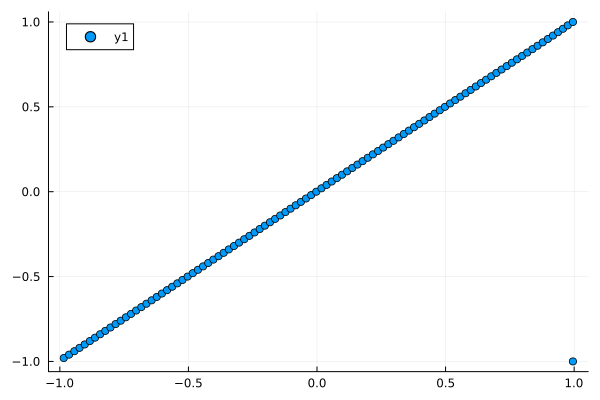

In [109]:
scatter(p1[end-1,:,1], phases)

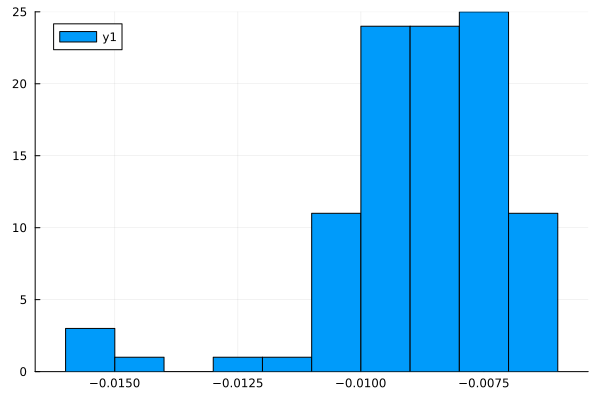

In [112]:
histogram(arc_error(err2))

In [113]:
stg = SpikeTrainGPU(st)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(92, 1), CartesianIndex(93, 1), CartesianIndex(94, 1), CartesianIndex(95, 1), CartesianIndex(96, 1), CartesianIndex(97, 1), CartesianIndex(98, 1), CartesianIndex(99, 1), CartesianIndex(100, 1), CartesianIndex(101, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101, 1), 101, 0.0f0)

In [29]:
using ChainRulesCore: ignore_derivatives

In [30]:
import .PhasorNetworks: gaussian_kernel

In [114]:
stg.indices

606-element CuArray{CartesianIndex{2}, 1, CUDA.DeviceMemory}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)
 CartesianIndex(3, 1)
 CartesianIndex(4, 1)
 CartesianIndex(5, 1)
 CartesianIndex(6, 1)
 CartesianIndex(7, 1)
 CartesianIndex(8, 1)
 CartesianIndex(9, 1)
 CartesianIndex(10, 1)
 CartesianIndex(11, 1)
 CartesianIndex(12, 1)
 CartesianIndex(13, 1)
 ⋮
 CartesianIndex(90, 1)
 CartesianIndex(91, 1)
 CartesianIndex(92, 1)
 CartesianIndex(93, 1)
 CartesianIndex(94, 1)
 CartesianIndex(95, 1)
 CartesianIndex(96, 1)
 CartesianIndex(97, 1)
 CartesianIndex(98, 1)
 CartesianIndex(99, 1)
 CartesianIndex(100, 1)
 CartesianIndex(101, 1)

In [115]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [116]:
stg.shape

(101, 1)

In [117]:
stg.linear_shape

101

In [35]:
# Set up sample data
n = 1_00
m = 100_000

# Create indices and values on the GPU
d_indices = rand(1:n, m) |> CuArray{Int}
d_values = CUDA.rand(Float32, m);

In [36]:
typeof(m)

Int64

In [37]:
d_indices

100000-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   4
   2
  32
  23
  43
  37
  97
  41
  85
  91
  57
  57
  82
   ⋮
  33
  95
  91
 100
  53
  22
  67
   4
  73
  30
  82
  40

In [38]:
v = parallel_scatter_add(d_indices, d_values, n)

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 509.63727
 483.25784
 509.51166
 491.85303
 525.1822
 537.73456
 527.36273
 499.69113
 474.75464
 485.90378
 506.0071
 520.6069
 479.83713
   ⋮
 502.21774
 516.7704
 475.138
 497.17023
 516.1097
 486.81113
 512.8835
 525.25995
 487.94965
 490.81787
 479.25305
 478.73682

In [39]:
for i in 1:1000 parallel_scatter_add(d_indices, d_values, n) end

In [40]:
for i in 1:10000 parallel_scatter_add(d_indices, d_values, n) end

In [41]:
#for i in 1:100000 parallel_scatter_add(d_indices, d_values, n) end

In [42]:
v

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 509.63727
 483.25784
 509.51166
 491.85303
 525.1822
 537.73456
 527.36273
 499.69113
 474.75464
 485.90378
 506.0071
 520.6069
 479.83713
   ⋮
 502.21774
 516.7704
 475.138
 497.17023
 516.1097
 486.81113
 512.8835
 525.25995
 487.94965
 490.81787
 479.25305
 478.73682

In [43]:
typeof(spk_args.t_window)

Float32

In [44]:
import .PhasorNetworks: gaussian_kernel_gpu

In [45]:
i0 = gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window))

606-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [46]:
for i in 1:1000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [47]:
for i in 1:10000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [48]:
ik = parallel_current(stg, 0.1f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 1.3887945f-11
 1.6052218f-9
 1.12535176f-7
 4.7851177f-6
 0.00012340969
 0.0019304542
 0.01831562
 0.1053992
 0.36787927
 0.77880085
 1.0
 0.77880085
 0.3678796
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.3887945f-11

In [49]:
iv = stack([parallel_current(stg, t, spk_args) for t in 0.0f0:0.01f0:1.1f0])

101×111 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          0.0
 0.778801     1.0          0.778801        0.0          0.0
 0.367879     0.778801     1.0             0.0          0.0
 0.105399     0.367879     0.778801        0.0          0.0
 0.0183156    0.105399     0.367879        0.0          0.0
 0.00193045   0.0183156    0.105399     …  0.0          0.0
 0.00012341   0.00193045   0.0183156       0.0          0.0
 4.78512f-6   0.00012341   0.00193045      0.0          0.0
 1.12535f-7   4.78512f-6   0.00012341      0.0          0.0
 1.60522f-9   1.12535f-7   4.7851f-6       0.0          0.0
 1.38879f-11  1.60522f-9   1.12535f-7   …  0.0          0.0
 7.28772f-14  1.38879f-11  1.60522f-9      0.0          0.0
 2.31952f-16  7.28772f-14  1.38879f-11     0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0        

In [50]:
iv2 = Array(iv);

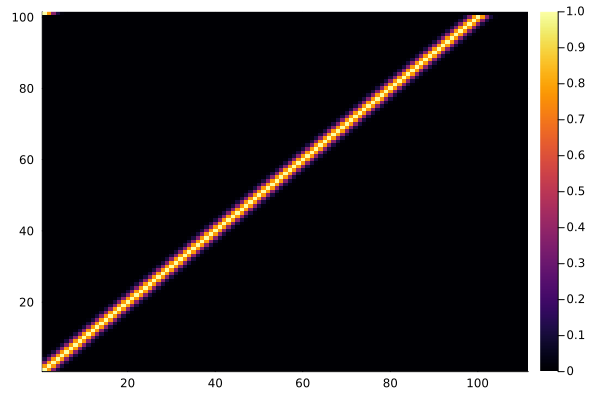

In [51]:
heatmap(iv2)

In [52]:
ival = spike_current(stg, 0.4f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

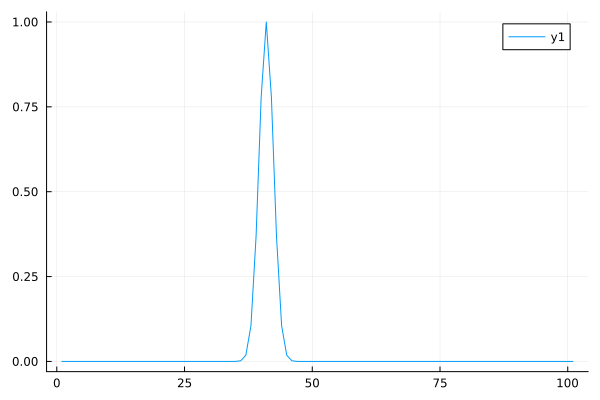

In [53]:
plot(Array(ival))

In [54]:
@time ivals = stack([Array(spike_current(stg, t, spk_args)) for t in 0.0f0:0.001f0:1.0f0], dims=1)

  0.206944 seconds (421.53 k allocations: 19.123 MiB, 80.16% compilation time)


1001×101 Matrix{Float32}:
 1.0       0.778801  0.367879  0.105399  …  0.0       0.0       1.0
 0.997503  0.816687  0.405555  0.122151     0.0       0.0       0.997503
 0.99005   0.852144  0.444858  0.140858     0.0       0.0       0.99005
 0.977751  0.884706  0.485537  0.161621     0.0       0.0       0.977751
 0.96079   0.913931  0.527292  0.18452      0.0       0.0       0.96079
 0.939413  0.939413  0.569783  0.209611  …  0.0       0.0       0.939413
 0.913931  0.96079   0.612626  0.236928     0.0       0.0       0.913931
 0.884706  0.977751  0.655406  0.266468     0.0       0.0       0.884706
 0.852144  0.99005   0.697676  0.298197     0.0       0.0       0.852144
 0.816687  0.997503  0.738968  0.33204      0.0       0.0       0.816687
 0.778801  1.0       0.778801  0.367879  …  0.0       0.0       0.778801
 0.738968  0.997503  0.816687  0.405555     0.0       0.0       0.738968
 0.697676  0.99005   0.852144  0.444858     0.0       0.0       0.697676
 ⋮                              

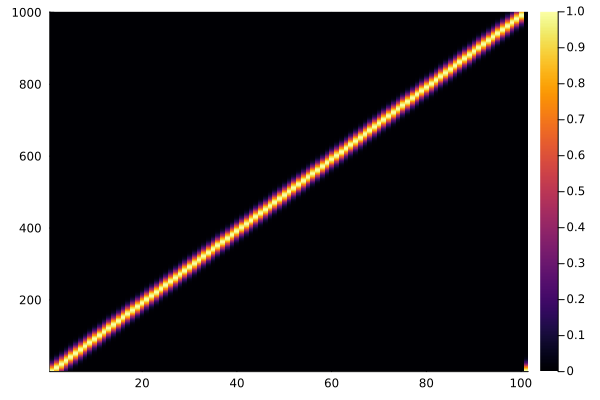

In [55]:
heatmap(ivals)

In [56]:
@time ivals2 = stack([Array(spike_current(st, t, spk_args)) for t in 0.0:0.001:1.0], dims=1);

  0.273145 seconds (1.12 M allocations: 55.855 MiB, 99.02% compilation time)


In [57]:
sum(abs2.(ivals .- ivals2))

31.03234f0

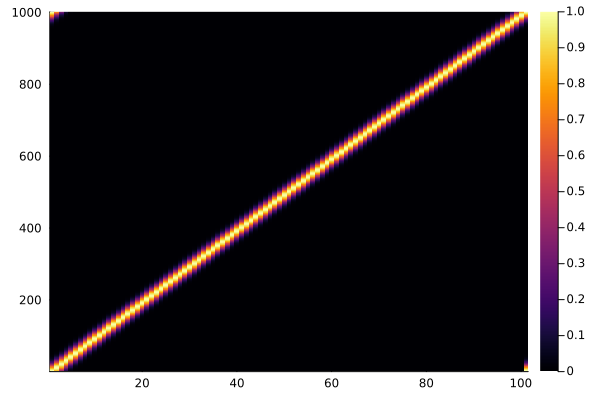

In [58]:
heatmap(ivals2)

In [59]:
spk_args

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [118]:
p1 = oscillator_bank(stg, spk_args=spk_args)

retcode: Success
Interpolation: 3rd order Hermite
t: 1001-element Vector{Float32}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.049999997
  0.059999995
  0.06999999
  0.07999999
  0.08999999
  0.09999999
  0.109999985
  0.11999998
  ⋮
  9.890131
  9.900131
  9.910131
  9.920132
  9.930132
  9.940132
  9.950132
  9.960133
  9.970133
  9.980133
  9.990133
 10.0
u: 1001-element Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}:
 [0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im;;]
 [0.008884004f0 + 0.00031415926f0im; 0.008886215f0 + 0.00024466746f0im; … ; 0.0f0 + 0.0f0im; 0.008884004f0 + 0.00031415926f0im;;]
 [0.014554631f0 + 0.001114661f0im; 0.017719582f0 + 0.0011150757f0im; … ; 0.0f0 + 0.0f0im; 0.014554631f0 + 0.001114661f0im;;]
 [0.01678964f0 + 0.002138472f0im; 0.023304893f0 + 0.0024664416f0im; … ; 0.0f0 + 0.0f0im; 0.01678964f0 + 0.002138472f0im;;]
 [0.017206376f0 + 0.0032159046f0im; 0.02542038f0 + 0.004033579f0im; … ; 0.0f0 + 0.0f0im; 0.017206376f0 + 0.0032159046f0im;;]

In [120]:
ph1 = solution_to_phase(p1, spk_args=spk_args)

101×1×1001 Array{Float64, 3}:
[:, :, 1] =
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
  ⋮
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552

[:, :, 2] =
 -0.9912514090538025
 -0.988761842250824
 -0.9864196181297302
 -0.9844556450843811
 -0.9829616546630859
 -0.9819071888923645
 -0.9812018275260925
 -0.9807465076446533
 -0.9804595112800598
 -0.9802811741828918
 -0.9801715016365051
 -0.9801043272018433
 -0.9800633788108826
  ⋮
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998

In [121]:
ph1c = Array(ph1)

101×1×1001 Array{Float64, 3}:
[:, :, 1] =
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
  ⋮
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552
 -0.9999999403953552

[:, :, 2] =
 -0.9912514090538025
 -0.988761842250824
 -0.9864196181297302
 -0.9844556450843811
 -0.9829616546630859
 -0.9819071888923645
 -0.9812018275260925
 -0.9807465076446533
 -0.9804595112800598
 -0.9802811741828918
 -0.9801715016365051
 -0.9801043272018433
 -0.9800633788108826
  ⋮
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998641968
 -0.9799998998

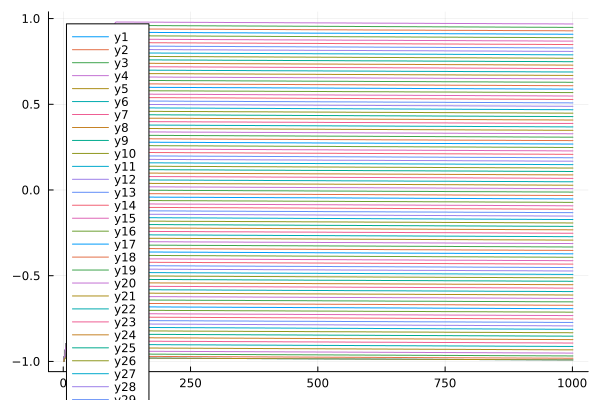

In [124]:
plot(ph1c[:,1,:]')

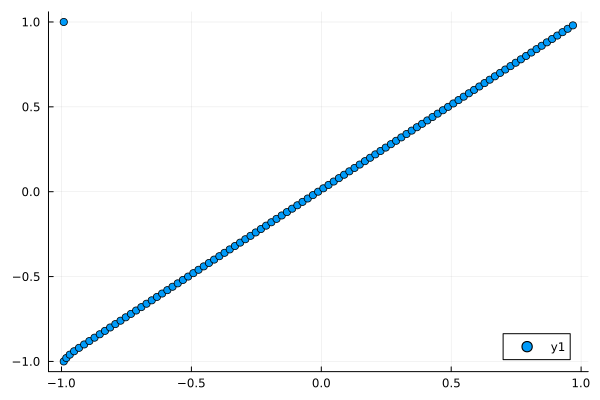

In [125]:
scatter(ph1c[:,1,end-1], phases)

In [63]:
biases = angle_to_complex(range(start=-1.0f0, stop=1.0f0, length=51)) |> cu

51-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
        -1.0f0 + 8.742278f-8im
  -0.9921147f0 - 0.1253332f0im
 -0.96858317f0 - 0.2486899f0im
 -0.92977655f0 - 0.3681244f0im
  -0.8763067f0 - 0.48175356f0im
 -0.80901706f0 - 0.5877852f0im
  -0.7289686f0 - 0.68454707f0im
   -0.637424f0 - 0.77051324f0im
  -0.5358269f0 - 0.84432787f0im
 -0.42577937f0 - 0.904827f0im
 -0.30901703f0 - 0.9510565f0im
 -0.18738131f0 - 0.9822872f0im
 -0.06279059f0 - 0.9980267f0im
               ⋮
 -0.18738131f0 + 0.9822872f0im
 -0.30901703f0 + 0.9510565f0im
 -0.42577937f0 + 0.904827f0im
  -0.5358269f0 + 0.84432787f0im
   -0.637424f0 + 0.77051324f0im
  -0.7289686f0 + 0.68454707f0im
 -0.80901706f0 + 0.5877852f0im
  -0.8763067f0 + 0.48175356f0im
 -0.92977655f0 + 0.3681244f0im
 -0.96858317f0 + 0.2486899f0im
  -0.9921147f0 + 0.1253332f0im
        -1.0f0 - 8.742278f-8im

In [64]:
typeof(biases) <: CuArray{<:Complex}

true

In [65]:
bias_current(biases, 0.4f0, 0.0f0, spk_args)

51-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.8f-44
 6.639575f-36
 1.6038108f-28
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [66]:
bivals = stack([bias_current(biases, t, 0.0f0, spk_args) for t in 0.0f0:0.01f0:1.0f0])

51×101 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          1.0
 0.367879     0.7788       1.0             0.0          0.367879
 0.0183155    0.105399     0.367879        0.0          0.0183155
 0.000123411  0.00193047   0.0183157       0.0          0.000123411
 1.12536f-7   4.78514f-6   0.00012341      0.0          1.12536f-7
 1.38879f-11  1.60523f-9   1.12535f-7   …  0.0          1.38879f-11
 2.31951f-16  7.28768f-14  1.38879f-11     0.0          2.31951f-16
 5.24281f-22  4.4777f-19   2.3195f-16      0.0          5.24281f-22
 1.60381f-28  3.72339f-25  5.24289f-22     0.0          1.60381f-28
 6.63958f-36  4.19009f-32  1.60379f-28     0.0          6.63958f-36
 3.8f-44      6.3816f-40   6.63968f-36  …  0.0          3.8f-44
 0.0          0.0          3.8f-44         0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.

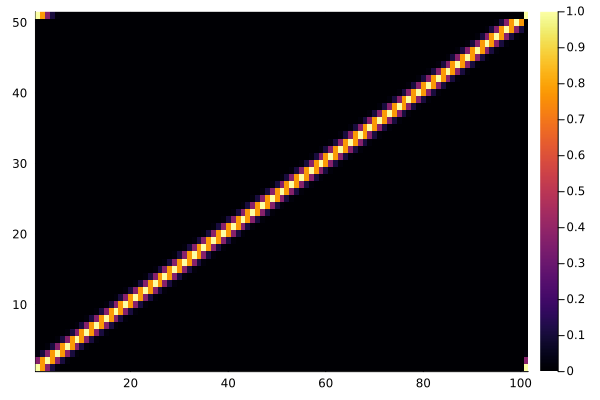

In [67]:
heatmap(Array(bivals))

In [68]:
update_fn = spk_args.update_fn

#27 (generic function with 1 method)

In [69]:
w = CUDA.ones((51,101));

In [70]:
w * bivals[1,:]

51-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 ⋮
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535

In [71]:
du = CUDA.zeros(ComplexF32, (51,))
u = CUDA.zeros(ComplexF32, (51,));

In [72]:
x = stg

SpikeTrainGPU(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(92,), CartesianIndex(93,), CartesianIndex(94,), CartesianIndex(95,), CartesianIndex(96,), CartesianIndex(97,), CartesianIndex(98,), CartesianIndex(99,), CartesianIndex(100,), CartesianIndex(101,)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101,), 101, 0.0f0)

In [73]:
b = biases;

In [80]:
tspan[2]

6.0

In [137]:
sol2 = oscillator_bank(stg, w, b, tspan=tspan, spk_args=spk_args)

retcode: Success
Interpolation: 3rd order Hermite
t: 601-element Vector{Float32}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.049999997
 0.059999995
 0.06999999
 0.07999999
 0.08999999
 0.09999999
 0.109999985
 0.11999998
 ⋮
 5.89004
 5.90004
 5.9100404
 5.9200406
 5.930041
 5.940041
 5.9500413
 5.9600415
 5.9700418
 5.980042
 5.990042
 6.0
u: 601-element Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}:
 [0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im;;]
 [0.044363823f0 + 0.0013422307f0im; 0.041209534f0 + 0.0011436442f0im; … ; 0.035479818f0 + 0.0010280715f0im; 0.044363823f0 + 0.0013422307f0im;;]
 [0.087876104f0 + 0.0055667004f0im; 0.087907396f0 + 0.0051711095f0im; … ; 0.07332147f0 + 0.0044520395f0im; 0.087876104f0 + 0.0055667004f0im;;]
 [0.12658757f0 + 0.012360264f0im; 0.13316484f0 + 0.012166793f0im; … ; 0.10979793f0 + 0.010221791f0im; 0.12658757f0 + 0.012360264f0im;;]
 [0.16184641f0 + 0.021422481f0im; 0.1735178f0 + 0.021853773f0im; … ; 0.14464004f0 + 0.018206578f0im; 0.1